In [73]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

You will develop a dynamic simulation of the system in Python, making use of the
guidelines as supplied during the computer tutorials, to calculate and graphically represent
the time responses of the outputs for step- and rectangular pulse disturbances in the
inputs.

Your simulation must allow changes in the heater inputs as well as disturbances in the
ambient conditions (temperature and air flow).

Make provision for the graphic representation of results and easy interaction.

Forward Euler integration should be sufficient if care is taken that the integration
step size is at least 10 times smaller than the smallest time constant in the differential
equations used to describe the process.

Your simulation must also allow for running concurrently with the TCLab unit showing
results from the real unit and your model on the same graphs in real time.

Marks for this phase will be awarded for

• Correct implementation of the model equations (30%)

• Successful integration of the model equations (30%)

• Presentation of results of simulation (30%)

• Programming style (10%)

$$Parameters$$

In [74]:
hinf   = 10.45             #W/m2/K
AF1    = 0.0004            #m2
Tinf   = 298.18            #K
AF2    = 0.0004            #m2
ϵ      = 0.85
σ      = 5.67*(10**-8)

In [75]:
Afin1  = Afin2  = 0.00009  #m-2
mF1    = mF2    = 0.0029   #kg
CpF1   = CpF2   = 502.42   #J/kg/K
ρF1    = ρF2    = 7900     #kg/m3
Vf1    = Vf2    = 0.00036  #m^-3
kH1    = kH2    = 14.4/1000#W/m/K
AH1    = AH2    = 0.00008  #m^2
LH1    = LH2    = 0.0015   #m

In [76]:
hH1    = hH2    = 10.45    #W/m^-2/K
mH1    = mH2    = 0.00019  #kg
CpH1   = CpH2   = 502.42   #J/kg/K
α1     = 0.01              #W
α2     = 0.075             #W

In [77]:
hS1    = hS2    = 10.45    #W/m2/K
AS1    = AS2    = 0.000016 #m2
mS1    = mS2    = 0.00025  #kg
CpS1   = CpS2   = 502.42   #J/kg/K

$$Inputs$$

In [78]:
Qin1   = 1.00             #W
Qin2   = 0.75             #W

In [79]:
import tclab
from tclab import TCLab, clock, Historian, Plotter, setup

In [80]:
def Q_rect(t, M0, M1, M2, ts1, ts2):
    if t < ts1:
        return M0
    
    elif ts1<t<ts2:
        return M1
    
    else:
        return M2
    
def Q_step(t, M0, M1, ts1):
    if t < ts1:
        return M0
    else:
        return M1

In [81]:
# Differential Equations

def diff(t, T):
    TF1, TF2, TH1, TH2, TS1, TS2 = T
    QIN1 = Q_step(t, 0, 100, 30)
    QIN2 = 0
        
    # Fin Equations

    Qconv_1 = hinf*AF1*(TF1 - Tinf)
    Qconv_2 = hinf*AF2*(TF2 - Tinf)

    Qcond_1 = ((kH1*AH1)/LH1)*(TH1 - TF1)#QH1_F1
    Qcond_2 = ((kH2*AH2)/LH2)*(TH2 - TF2)#QH2_F2

    Qrad_1 = ϵ*σ*AF1*((TF1**4) - (Tinf**4))
    Qrad_2 = ϵ*σ*AF2*((TF2**4) - (Tinf**4))

    Qconv_12 = hinf*(Afin1 + Afin2)*(TF1 - TF2)
    Qrad_12 = ϵ*σ*(Afin1 + Afin2)*((TF1**4) - (TF2**4))
    
    # Heater Equations

    QH1_F1 = ((kH1*AH1)/LH1)*(TH1 - TF1)
    QH2_F2 = ((kH2*AH2)/LH2)*(TH2 - TF2)

    QH1_S1 = ((kH1*AH1)/LH1)*(TH1 - TS1)
    QH2_S2 = ((kH2*AH2)/LH2)*(TH2 - TS2)

    QH1_conv = hH1*AH1*(TH1 - Tinf)
    QH2_conv = hH2*AH2*(TH2 - Tinf)

    QH1_rad = ϵ*σ*AH1*((TH1**4) - (Tinf**4))
    QH2_rad = ϵ*σ*AH2*((TH2**4) - (Tinf**4))
    
    # Sensor Equations

    QS1_cond = QH1_S1
    QS2_cond = QH2_S2

    QS1_conv = hS1*AS1*(TS1 - Tinf)
    QS2_conv = hS2*AS2*(TS2 - Tinf)

    QS1_rad = ϵ*σ*AS1*((TS1**4) - (Tinf**4))
    QS2_rad = ϵ*σ*AS2*((TS2**4) - (Tinf**4))
    
    # Differential Equations
    
    dTF1dt = (1/(mF1*CpF1))*(-Qconv_1 - Qrad_1 + Qcond_1 - Qconv_12 - Qrad_12)
    dTF2dt = (1/(mF2*CpF2))*(-Qconv_2 - Qrad_2 + Qcond_2 + Qconv_12 + Qrad_12)

    dTH1dt = (1/(mH1*CpH1))*(-QH1_F1 - QH1_S1 - QH1_conv - QH1_rad + α1*QIN1)
    dTH2dt = (1/(mH2*CpH2))*(-QH2_F2 - QH2_S2 - QH2_conv - QH2_rad + α2*QIN2)

    dTS1dt = (1/(mS1*CpS1))*(QS1_cond - QS1_rad - QS1_conv)
    dTS2dt = (1/(mS2*CpS2))*(QS2_cond - QS2_rad - QS2_conv)

    return dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt

In [ ]:
TCLab  = setup(connected = False, speedup = 1)
tfinal = 150
t_step = 1

In [ ]:
tspan  = []

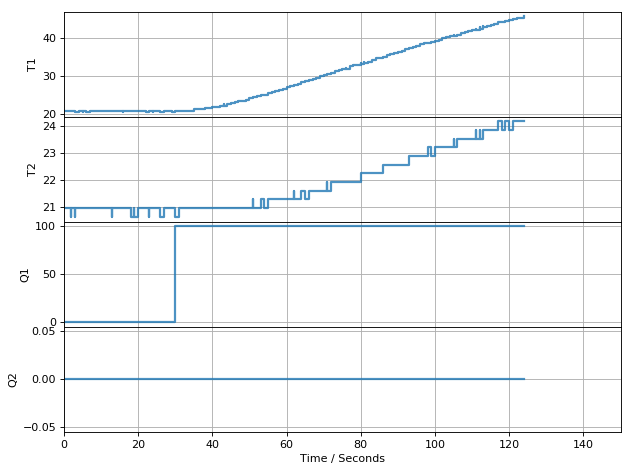

In [ ]:
with TCLab() as lab:
    hist = Historian(lab.sources)
    p = Plotter(hist, tfinal)
    dt = t_step
    To = [298.15, 298.15, 298.15, 298.15, 298.15, 298.15]
    TF1, TF2, TH1, TH2, TS1, TS2 = To
    TS1s = []
    Tlab1 = []

    for t in tclab.clock(tfinal, t_step):
        
        lab.Q1(Q_step(t, 0, 100, 30))
        lab.Q2(0)

        To = TF1, TF2, TH1, TH2, TS1, TS2 
        dTF1dt, dTF2dt, dTH1dt, dTH2dt, dTS1dt, dTS2dt = diff(t, To)

        TF1 += dTF1dt*dt
        TF2 += dTF2dt*dt
        TH1 += dTH1dt*dt
        TH2 += dTH2dt*dt
        TS1 += dTS1dt*dt
        TS2 += dTS2dt*dt

        To = TF1, TF2, TH1, TH2, TS1, TS2
        TS1s.append(TS1-273.15)
        Tlab1.append(lab.T1)
        tspan.append(t)
        hist.update(t)
        p.update(t)

In [ ]:
TS1s

In [ ]:
plt.plot(tspan, TS1s)
plt.plot(tspan, Tlab1)